# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by Andrea Rausa

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [10]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [11]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [12]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9793 / 11441 MB available


In [14]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;

    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel( float* c, float* a, float* b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;  // Idx = Index
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    unsigned int k = j * cols + i; // I'm using linear indexes for going through the matrix
    
    // Pseudocode
    // c[j][i] = a[j][i] + b[j][i]
    
    c[k] = a[k] + b[k];
}

__global__ void multMatVecKernel( float* c, float* a, float* b, int cols){
   
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    float sum = 0.0f;
       
        //don't use vectors in kernel
       
       for (int i = 0; i < cols; i++){
       
           unsigned int k = j * cols + i;
           sum += a[k] * b[i]; // I move result into a temporary variable.
       }
       c[j] = sum;
}

//__global__ void multMatMatKernel( float* c, float* a, float* b, int cols_a, int rows_b, int cols_b){
   // unsigned int l = blockIdx.x*blockDim.x + threadIdx.x;
   // unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
   // float sum = 0.0f;
       //
       // don't use vectors in kernel
       
    //
      // for (int i = 0; i< cols_a; i++){
      //     for( int t = 0; t < rows_b; t++)       
      //     unsigned int k = j * cols_a + i;
      //     unsigned int f = t * cols_b + l;
       //    sum += a[k] * b[i]; // I move result into a temporary variable.
     //  }
      // c[k] = sum;
//}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("multMatVecKernel");

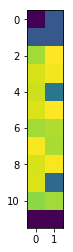

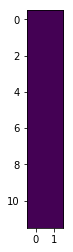

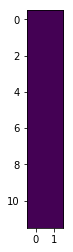

In [15]:
testing_variable = np.empty((12,2))
plt.figure()
plt.imshow(testing_variable)

testing_variable = np.zeros((12,2), dtype = np.float32)
plt.figure()
plt.imshow(testing_variable)

testing_variable = np.ones((12,2))
plt.figure()
plt.imshow(testing_variable)

<bound method Figure.show of <matplotlib.figure.Figure object at 0x7f40c8fd9978>>

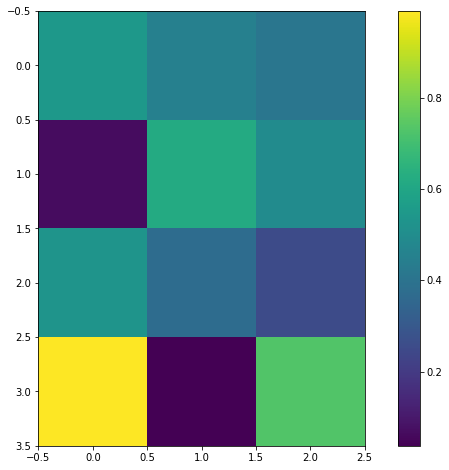

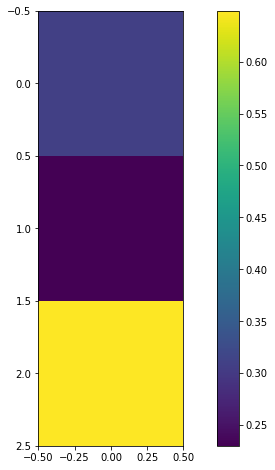

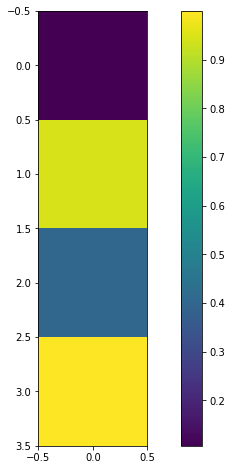

In [17]:
#Size of our test
test_size = (4, 3)  # always try to use different sizes for columns and rows
#test_size_2 = (6, 12)
#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random((3,1)).astype(np.float32)
#b = np.random.random(test_size_2).astype(np.float32)
#c = np.random.random((test_size[0], test_size_2[1])).astype(np.float32)
c = np.random.random((4,1)).astype(np.float32)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show

fig = plt.figure(figsize=(12,8))
plt.imshow(b)
plt.colorbar()
fig.show

fig = plt.figure(figsize=(12,8))
plt.imshow(c)
plt.colorbar()
fig.show

In [18]:
print(a.shape)
print(b.shape)
print(c.shape)

(4, 3)
(3, 1)
(4, 1)


In [19]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [20]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [21]:
# a.shape = [rows, columns] => [y,x] I have to transpose it 'cause in the kernel we've done it

domain_size = (a.shape[1], a.shape[0]) # now domain is in [x, y, z]
block_size = (3, 2, 1)
grid_size = (domain_size[0]//block_size[0], domain_size[1]//block_size[1], 1)  # // is integer division and / is real division. we want integers

#domain_size_2 = (b.shape[1], b.shape[0]) # now domain is in [x, y, z]
#block_size_2 = (3, 2, 1)
#grid_size_2 = (domain_size_2[0]//block_size_2[0], domain_size_2[1]//block_size_2[1], 1)  # // is integer division and / is real division. we want integers

print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size)) 
print("Domain size is " + str(domain_size))

#print("Block_2 size is " + str(block_size_2))
#print("Grid_2 size is " + str(grid_size_2)) 
#print("Domain_2 size is " + str(domain_size_2))

Block size is (3, 2, 1)
Grid size is (1, 2, 1)
Domain size is (3, 4)


In [22]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block = block_size, grid = grid_size) # I have to pass the exact value of domain_size[1]

In [23]:
print(c.dtype)

float32


In [24]:
#Copy data from device to host
c_g.get(c)

array([[0.5403509 ],
       [0.48617095],
       [0.4157619 ],
       [0.78873944]], dtype=float32)

In [25]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref))) # Sum of absolute differences

C   =  [[0.5403509 ]
 [0.48617095]
 [0.4157619 ]
 [0.78873944]]
Ref =  [[0.5403509 ]
 [0.48617095]
 [0.4157619 ]
 [0.78873944]]
Sad =  0.0


In [26]:
print(c.shape)

(4, 1)


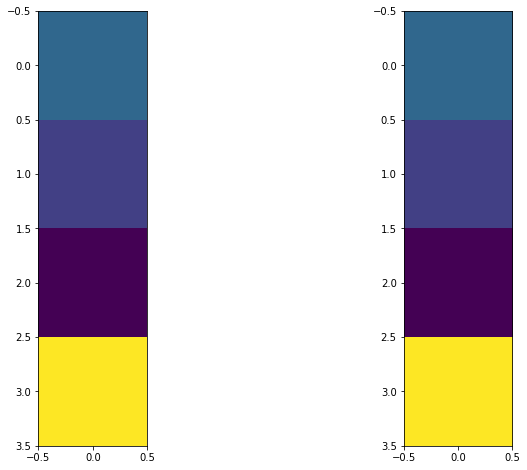

In [28]:
fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(c)
plt.subplot(1, 2, 2)
plt.imshow(c_ref)